In [1]:
!pip install -q tensorflow dmba scikeras graphviz pydot xgboost lightgbm

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
import itertools, random, os, json, joblib, platform

from numpy import arange
from pandas import set_option
from pandas.plotting import scatter_matrix

2025-10-19 14:57:21.857359: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-19 14:57:21.886816: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from sklearn import impute
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


from xgboost import XGBClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Input, Dense, Dropout

In [4]:
%matplotlib inline

In [5]:
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

## Data Preprocessing

In [6]:
data = pd.read_csv("../Data/USCensusTraining.csv", sep=',', header=0)

In [7]:
data.head(10)

,age,workclass,demogweight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K.
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K.
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K.
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K.
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K.
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K.
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K.
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K.
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K.
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K.


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             25000 non-null  int64 
 1   workclass       25000 non-null  object
 2   demogweight     25000 non-null  int64 
 3   education       25000 non-null  object
 4   education-num   25000 non-null  int64 
 5   marital-status  25000 non-null  object
 6   occupation      25000 non-null  object
 7   relationship    25000 non-null  object
 8   race            25000 non-null  object
 9   sex             25000 non-null  object
 10  capital-gain    25000 non-null  int64 
 11  capital-loss    25000 non-null  int64 
 12  hours-per-week  25000 non-null  int64 
 13  native-country  25000 non-null  object
 14  income          25000 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.9+ MB


**We drop `education` column because it is duplicate with `education-num` column, same information**

In [9]:
df = data.drop(columns=['education'])

In [10]:
categorical = ["workclass", "marital-status", "occupation", 
               "relationship", "race", "sex", "native-country"]
numerical = ["age", "demogweight", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

In [11]:
print(df["relationship"].value_counts())

print(df["marital-status"].value_counts())

relationship
Husband           10064
Not-in-family      6443
Own-child          3911
Unmarried          2640
Wife               1213
Other-relative      729
Name: count, dtype: int64
marital-status
Married-civ-spouse       11441
Never-married             8225
Divorced                  3435
Separated                  786
Widowed                    769
Married-spouse-absent      328
Married-AF-spouse           16
Name: count, dtype: int64


In [12]:
df.describe()

,age,demogweight,education-num,capital-gain,capital-loss,hours-per-week
count,25000.000000,2.500000e+04,25000.000000,25000.000000,25000.00000,25000.000000
mean,38.606920,1.897418e+05,10.081440,1088.579040,86.49992,40.407440
std,13.687769,1.052947e+05,2.557035,7486.621197,401.25358,12.299267
min,17.000000,1.228500e+04,1.000000,0.000000,0.00000,1.000000
25%,28.000000,1.179630e+05,9.000000,0.000000,0.00000,40.000000
50%,37.000000,1.783530e+05,10.000000,0.000000,0.00000,40.000000
75%,48.000000,2.368610e+05,12.000000,0.000000,0.00000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.00000,99.000000


**`desctibe()` function only shows info of numeric columns, we can see capital-gain and capital-loss has first 3 qunatiles all equal to 0, ==> something we need to do here**

In [13]:
df['income'].value_counts()

income
<=50K.    19016
>50K.      5984
Name: count, dtype: int64

**We can see the data is not quite balanced, 19016 observations have income $\le$50K, but only 5984 observation has income >50K, ==> should stratify on y when split data**

**We also turn the response variable `income` into a inary variable represented by 1 and 0 for >50K and <=50K**

In [14]:
df['income'] = df['income'].replace({'>50K.': 1, '<=50K.': 0})

/tmp/ipykernel_2107886/2949542690.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['income'] = df['income'].replace({'>50K.': 1, '<=50K.': 0})


In [15]:
df.head(10)

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
5,37,Private,284582,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
6,49,Private,160187,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,0
7,52,Self-emp-not-inc,209642,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
8,31,Private,45781,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,1
9,42,Private,159449,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,1


In [16]:
df['workclass'].value_counts()

workclass
Private             17385
Self-emp-not-inc     1978
Local-gov            1624
?                    1399
State-gov             993
Self-emp-inc          857
Federal-gov           750
Without-pay             9
Never-worked            5
Name: count, dtype: int64

In [17]:
df[data.workclass == "?"]

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27,54,?,180211,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,1
61,32,?,293936,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,0
69,25,?,200681,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,0
77,67,?,212759,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,0
106,17,?,304873,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24894,62,?,141218,14,Married-civ-spouse,?,Husband,White,Male,0,0,30,United-States,1
24902,61,?,202106,9,Married-civ-spouse,?,Husband,White,Male,0,1902,40,United-States,1
24913,19,?,199495,10,Never-married,?,Own-child,White,Male,0,0,60,United-States,0
24949,36,?,187983,9,Never-married,?,Unmarried,White,Female,0,0,40,United-States,0


In [18]:
df['occupation'].value_counts()

occupation
Prof-specialty       3180
Craft-repair         3122
Exec-managerial      3084
Adm-clerical         2975
Sales                2815
Other-service        2555
Machine-op-inspct    1536
?                    1404
Transport-moving     1228
Handlers-cleaners    1000
Farming-fishing       767
Tech-support          703
Protective-serv       503
Priv-house-serv       121
Armed-Forces            7
Name: count, dtype: int64

In [19]:
df[data.occupation == "?"]

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27,54,?,180211,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,1
61,32,?,293936,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,0
69,25,?,200681,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,0
77,67,?,212759,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,0
106,17,?,304873,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24894,62,?,141218,14,Married-civ-spouse,?,Husband,White,Male,0,0,30,United-States,1
24902,61,?,202106,9,Married-civ-spouse,?,Husband,White,Male,0,1902,40,United-States,1
24913,19,?,199495,10,Never-married,?,Own-child,White,Male,0,0,60,United-States,0
24949,36,?,187983,9,Never-married,?,Unmarried,White,Female,0,0,40,United-States,0


In [20]:
df['native-country'].value_counts()

native-country
United-States                 22421
Mexico                          488
?                               445
Philippines                     151
Germany                         102
Canada                           99
Puerto-Rico                      96
El-Salvador                      72
Cuba                             72
England                          72
India                            67
South                            64
China                            60
Jamaica                          58
Italy                            55
Dominican-Republic               54
Vietnam                          50
Guatemala                        50
Poland                           49
Japan                            48
Columbia                         45
Taiwan                           42
Haiti                            38
Iran                             35
Portugal                         28
Nicaragua                        25
Peru                             23
Greece       

In [21]:
df[data["native-country"] == "?"]

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14,40,Private,121772,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,?,1
38,31,Private,84154,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,?,1
51,18,Private,226956,9,Never-married,Other-service,Own-child,White,Female,0,0,30,?,0
61,32,?,293936,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,0
93,30,Private,117747,9,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,1573,35,?,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24890,32,Private,39223,6,Separated,Craft-repair,Unmarried,Black,Female,0,0,40,?,0
24891,55,State-gov,117357,16,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,70,?,1
24923,68,Private,208478,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,18,?,0
24960,20,Private,107242,9,Never-married,Machine-op-inspct,Not-in-family,Black,Male,0,0,40,?,0


In [22]:
X = df.iloc[:, :13]
y = df.iloc[:, -1]

In [23]:
X

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,41,Private,112507,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,60,United-States
24996,19,Private,236940,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,40,United-States
24997,33,Private,278514,9,Divorced,Craft-repair,Own-child,White,Female,0,0,42,United-States
24998,21,?,433330,10,Never-married,?,Unmarried,White,Male,0,0,40,United-States


In [24]:
y

0        0
1        0
2        0
3        0
4        0
        ..
24995    0
24996    0
24997    0
24998    0
24999    0
Name: income, Length: 25000, dtype: int64

In [25]:
# build preprocessor using pipelines for future transformation
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

In [26]:
# split the training data into train validate sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# fit preprocessor, transform to dense arrays
X_train_enc = preprocessor.fit_transform(X_train)
X_val_enc = preprocessor.transform(X_val)

X_train_enc = X_train_enc.toarray()
X_val_enc = X_val_enc.toarray()

In [27]:
pd.DataFrame(X_train_enc).describe()

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,0.295970,0.120420,0.605687,0.011198,0.019853,0.402033,0.056200,0.029700,0.065000,0.000200,...,0.001250,0.00390,0.000300,0.002800,0.001700,0.000450,0.000500,0.897550,0.002050,0.00025
std,0.188087,0.071273,0.170541,0.076934,0.092485,0.125327,0.230313,0.169763,0.246532,0.014141,...,0.035334,0.06233,0.017318,0.052842,0.041197,0.021209,0.022356,0.303247,0.045232,0.01581
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.150685,0.071867,0.533333,0.000000,0.000000,0.397959,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
50%,0.273973,0.112807,0.600000,0.000000,0.000000,0.397959,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
75%,0.424658,0.152282,0.733333,0.000000,0.000000,0.448980,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## Part One

### a. 
### Generate a neural network to predict income using the other attributes. You may need to ignore one of the attributes. Describe the topology of the resulting network and draw a detailed picture of the network topology, labeling the input and output layers.

In [28]:
model = Sequential([
    Input(shape=(X_train_enc.shape[1],), name='input'),
    Dense(32, activation='relu', kernel_initializer='glorot_uniform', name='hidden_layer1'),
    Dense(1, activation='sigmoid', name='output')
], name='ANN')

model.compile(
    optimizer=RMSprop(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [29]:
history = model.fit(X_train_enc, y_train, epochs=40, batch_size=16, validation_split=0.2, verbose=2)

Epoch 1/40
1000/1000 - 1s - 1ms/step - accuracy: 0.8161 - loss: 0.3940 - val_accuracy: 0.8280 - val_loss: 0.3645
Epoch 2/40
1000/1000 - 1s - 909us/step - accuracy: 0.8363 - loss: 0.3523 - val_accuracy: 0.8340 - val_loss: 0.3530
Epoch 3/40
1000/1000 - 1s - 942us/step - accuracy: 0.8421 - loss: 0.3427 - val_accuracy: 0.8342 - val_loss: 0.3459
Epoch 4/40
1000/1000 - 1s - 919us/step - accuracy: 0.8446 - loss: 0.3368 - val_accuracy: 0.8388 - val_loss: 0.3409
Epoch 5/40
1000/1000 - 1s - 908us/step - accuracy: 0.8459 - loss: 0.3328 - val_accuracy: 0.8403 - val_loss: 0.3377
Epoch 6/40
1000/1000 - 1s - 900us/step - accuracy: 0.8469 - loss: 0.3299 - val_accuracy: 0.8420 - val_loss: 0.3353
Epoch 7/40
1000/1000 - 1s - 911us/step - accuracy: 0.8483 - loss: 0.3277 - val_accuracy: 0.8425 - val_loss: 0.3338
Epoch 8/40
1000/1000 - 1s - 910us/step - accuracy: 0.8496 - loss: 0.3261 - val_accuracy: 0.8428 - val_loss: 0.3324
Epoch 9/40
1000/1000 - 1s - 903us/step - accuracy: 0.8506 - loss: 0.3250 - val_acc

**Draw Topology of the neural network model:**

In [30]:
def vertical_positions(n_nodes, x, y_center=0.0, v_spacing=0.55):
    if n_nodes == 1:
        return [(x, y_center)]
    total_h = (n_nodes - 1) * v_spacing
    y0 = y_center - total_h/2
    return [(x, y0 + i*v_spacing) for i in range(n_nodes)]

def grid_positions(n_nodes, x, y_center=0.0, ncols=5, h_spacing=0.55, v_spacing=0.38):
    nrows = math.ceil(n_nodes / ncols)
    total_h = (nrows - 1) * v_spacing
    total_w = (ncols - 1) * h_spacing
    y0 = y_center - total_h/2
    x0 = x - total_w/2
    pts, k = [], 0
    for c in range(ncols):
        for r in range(nrows):
            if k >= n_nodes: break
            pts.append((x0 + c*h_spacing, y0 + r*v_spacing))
            k += 1
    return pts

def draw_nodes(ax, positions, radius=0.13, label=None, label_dy=0.8):
    for (x, y) in positions:
        ax.add_patch(plt.Circle((x, y), radius, fill=False, lw=1.2, zorder=3))
    if label:
        maxy = max(y for _, y in positions)
        meanx = sum(x for x, _ in positions) / len(positions)
        ax.text(meanx, maxy + label_dy, label, ha='center', va='bottom',
                fontsize=11, weight='bold', zorder=5)

def connect_layers(ax, src, dst, mode='sparse', sample_src=12, sample_dst=12,
                   lw=0.35, alpha=0.6, color='0.7'):
    """mode='full' draws ALL edges; 'sparse' samples evenly."""
    if not src or not dst:
        return
    if mode == 'full':
        src_s, dst_s = src, dst
    else:
        def pick(pts, k):
            if len(pts) <= k: return pts
            step = max(1, len(pts)//k)
            return pts[::step][:k]
        src_s = pick(src, sample_src)
        dst_s = pick(dst, sample_dst)

    for (x1, y1) in src_s:
        for (x2, y2) in dst_s:
            ax.plot([x1, x2], [y1, y2], lw=lw, alpha=alpha, color=color, zorder=1)

# ---------- main drawer ----------
def draw_ann_topology(input_dim=92, hidden_units=32,
                      show_all_inputs=True, input_grid_cols=5,
                      connect='full',  # 'full' or 'sparse'
                      filename='ann_topology.png'):
    x_in, x_hidden, x_out = 0.0, 3.6, 7.2
    fig, ax = plt.subplots(figsize=(11, 6))

    # Input layer (grid keeps 92 tidy)
    if show_all_inputs:
        inp_pos = grid_positions(input_dim, x_in, y_center=0.0,
                                 ncols=input_grid_cols, h_spacing=0.55, v_spacing=0.38)
    else:
        inp_pos = vertical_positions(min(12, input_dim), x_in, v_spacing=0.45)
        ax.text(x_in, min(y for _, y in inp_pos)-0.9, "…", ha='center', va='top', fontsize=14)
    draw_nodes(ax, inp_pos, label=f"Input  (features = {input_dim})")

    # Hidden (32 neatly stacked)
    hid_pos = vertical_positions(hidden_units, x_hidden, v_spacing=0.45)
    draw_nodes(ax, hid_pos, label=f"Hidden  (units = {hidden_units}, activation = ReLU)")

    # Output (1)
    out_pos = vertical_positions(1, x_out, v_spacing=0.45)
    draw_nodes(ax, out_pos, label="Output  (units = 1, activation = Sigmoid)\nP(income > 50K)")

    # Connections
    connect_layers(ax, inp_pos, hid_pos, mode=connect,
                   sample_src=12, sample_dst=min(12, hidden_units),
                   lw=0.3, alpha=0.55, color='0.7')
    connect_layers(ax, hid_pos, out_pos, mode='full', lw=0.6, alpha=0.9, color='0.3')

    # Cosmetics
    all_y = [y for _, y in (inp_pos + hid_pos + out_pos)]
    ax.set_xlim(x_in-1.2, x_out+1.2)
    ax.set_ylim(min(all_y)-1.8, max(all_y)+2.2)
    ax.axis('off')
    plt.title("ANN Topology — Input(92) → Dense(32, ReLU) → Output(1, Sigmoid)", pad=10)
    plt.savefig(filename, dpi=240, bbox_inches='tight')
    plt.close()
    print(f"Saved: {filename}")

draw_ann_topology(input_dim=92, hidden_units=32,
                      show_all_inputs=True, input_grid_cols=6,
                      connect='full', filename='ann_topology_full.png')

Saved: ann_topology_full.png


### b.

### Which are the most important variables for predicting income?

In [31]:
def model_predict_proba(model, preprocessor, row_df):
    X_enc = preprocessor.transform(row_df).toarray()
    return float(model.predict(X_enc, verbose=0).ravel()[0])


numeric_means = X_train[numerical].mean(numeric_only=True)
categorical_modes = X_train[categorical].mode().iloc[0]

baseline_row = pd.DataFrame({**numeric_means.to_dict(),
                             **categorical_modes.to_dict()}, index=[0])
baseline_prob = model_predict_proba(model, preprocessor, baseline_row)
print(f"\nBaseline prob (>50K): {baseline_prob:.4f}")


Baseline prob (>50K): 0.5252


In [32]:
# numeric sensitivity: set feature to train min and train max
num_results = []
train_mins = X_train[numerical].min(numeric_only=True)
train_maxs = X_train[numerical].max(numeric_only=True)

for col in numerical:
    # min test
    row_min = baseline_row.copy()
    row_min[col] = train_mins[col]
    p_min = model_predict_proba(model, preprocessor, row_min)

    # max test
    row_max = baseline_row.copy()
    row_max[col] = train_maxs[col]
    p_max = model_predict_proba(model, preprocessor, row_max)
    
    abs_min = float(abs(p_min - baseline_prob))
    abs_max = float(abs(p_max - baseline_prob))

    num_results.append({
        'feature': col,
        'baseline_prob': baseline_prob,
        'prob_at_min': p_min,
        'prob_at_max': p_max,
        'abs_change_min': abs(p_min - baseline_prob),
        'abs_change_max': abs(p_max - baseline_prob),
        'mean_abs_change': float(np.mean([abs_min, abs_max])),
        'range_prob': p_max - p_min
    })
    
    
num_df = pd.DataFrame(num_results).sort_values('mean_abs_change', ascending=False)
print("\nTop numeric sensitivities (by max abs change from baseline):")
print(num_df[['feature','baseline_prob','prob_at_min','prob_at_max','mean_abs_change']].head(15))


Top numeric sensitivities (by max abs change from baseline):
          feature  baseline_prob  prob_at_min  prob_at_max  mean_abs_change
2   education-num       0.525237     0.170379     0.849714         0.339668
3    capital-gain       0.525237     0.429456     1.000000         0.285272
5  hours-per-week       0.525237     0.278141     0.847403         0.284631
4    capital-loss       0.525237     0.510923     0.990675         0.239876
0             age       0.525237     0.330702     0.781568         0.225433
1     demogweight       0.525237     0.516779     0.585441         0.034331


In [33]:
# categorical sensitivity: flip one categorical to each of its observed categories
cat_results = []

# Pull categories from fitted OneHotEncoder (aligned to categorical_cols)
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
ohe_categories = ohe.categories_  # list of arrays, one per categorical col

for col, cats in zip(categorical, ohe_categories):
    # Iterate each category value for this column
    probs = []
    changes = []
    for val in cats:
        row_cat = baseline_row.copy()
        row_cat[col] = val
        p = model_predict_proba(model, preprocessor, row_cat)
        probs.append((val, p))
        changes.append(float(abs(p - baseline_prob)))

    # summarize
    probs_sorted = sorted(probs, key=lambda t: t[1])
    min_cat, min_prob = probs_sorted[0]
    max_cat, max_prob = probs_sorted[-1]
    mean_abs_change = float(np.mean(changes))

    cat_results.append({
        'feature': col,
        'baseline_prob': baseline_prob,
        'min_prob': min_prob,
        'min_prob_cat': min_cat,
        'max_prob': max_prob,
        'max_prob_cat': max_cat,
        'range_prob': max_prob - min_prob,
        'mean_abs_change_from_baseline': mean_abs_change
    })

cat_df = pd.DataFrame(cat_results).sort_values('mean_abs_change_from_baseline', ascending=False)
print("\nTop categorical sensitivities (by max abs change from baseline):")
print(cat_df[['feature','baseline_prob','min_prob','min_prob_cat','max_prob','max_prob_cat','mean_abs_change_from_baseline']].head(15))


Top categorical sensitivities (by max abs change from baseline):
          feature  baseline_prob  min_prob           min_prob_cat  max_prob  \
1  marital-status       0.525237  0.148893  Married-spouse-absent  0.984102   
2      occupation       0.525237  0.119142        Farming-fishing  0.789478   
3    relationship       0.525237  0.217082         Other-relative  0.822831   
6  native-country       0.525237  0.177135                 Mexico  0.841392   
0       workclass       0.525237  0.198249                      ?  0.764736   
4            race       0.525237  0.247985                  Other  0.617474   
5             sex       0.525237  0.338782                 Female  0.525237   

        max_prob_cat  mean_abs_change_from_baseline  
1  Married-AF-spouse                       0.295945  
2                  ?                       0.198428  
3               Wife                       0.195006  
6              Japan                       0.165460  
0        Federal-gov           

**From this we can see that top 3 important numerical variables are: `capital-gain`, `hours-per-week`, and `education-num`**

**From this we can see that top 3 important categorical variables are: `marital-status`, `occupation`, and `relationship`**

### c.

### What is the predicted accuracy? What does this number mean?

In [34]:
predictions = model.predict(X_val_enc)

rounded = [round(x[0]) for x in predictions]

loss, acc = model.evaluate(X_val_enc, y_val, verbose=2)
print(f"Validation set Accuracy: {acc:.3f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
157/157 - 0s - 1ms/step - accuracy: 0.8536 - loss: 0.3238
Validation set Accuracy: 0.854


**The predicted accuracy is 0.852. This means about 85\% of rows in validation set are classified correctly (both “≤50K” and “>50K”).**

### d.

### Compare the predicted income with actual income. Which error is the model more prone to making? Is this type of error more protective of, say, banks or loan applicants?

In [35]:
print(confusion_matrix(y_val, rounded))

[[3522  281]
 [ 451  746]]


**The False Negaives are more prone to making. That means the model more often predicts “≤50K” when the true income is “>50K.” In other words, it tends to under-predict income at the default threshold.**

**This pattern is generally more protective of banks since there will be fewer approvals. But it’s harsher on applicants, because some truly “>50K” applicants may be incorrectly treated as lower income and therefore be denied**

### e.

### Which occupations are associated with predicted income over 50,000 dollar? Which education levels? Which ages? Is this intuitive? Construct graphs of the top three categorical predictors, and their relationship to predicted income. Make sure you fine-tune these graphs, and arrange the graphs so that they are truly helpful.

- **Bar chart for `Age` and `Education Level`, `Age` split into bins based on quantiles, `Education Level` split into bins based on most common levels**

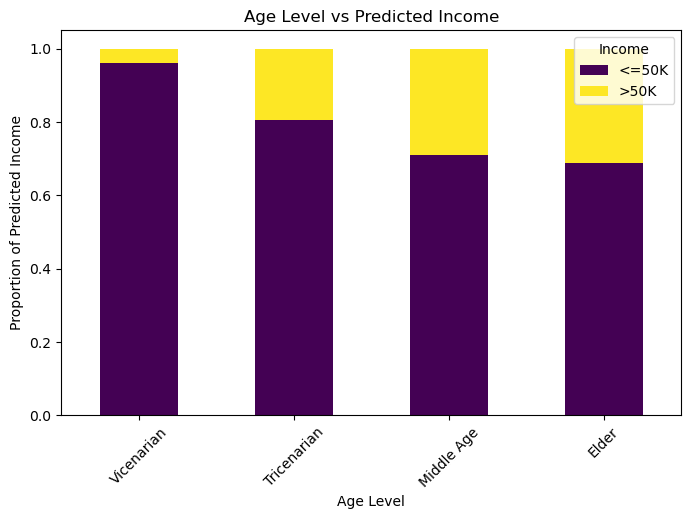

In [36]:
X_val_pred = X_val
X_val_pred["predicted_income"] = rounded
bins = [17, 28, 37, 47, X_val_pred['age'].max()]
labels = ['Vicenarian', 'Tricenarian', 'Middle Age', 'Elder']
X_val_pred['age_bin'] = pd.cut(
    X_val_pred['age'], bins=bins, labels=labels, include_lowest=True
)


age_crosstab = pd.crosstab(
    X_val_pred['age_bin'],
    X_val_pred['predicted_income'],
    normalize='index'
)

age_crosstab.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5),
    colormap='viridis'
)
plt.ylabel('Proportion of Predicted Income')
plt.xlabel('Age Level')
plt.title('Age Level vs Predicted Income')
plt.legend(title='Income', labels=['<=50K', '>50K'])
plt.xticks(rotation=45)
plt.show()

**We can see that older people tend to be associated with predicted income over 50,000 dollar. This is intuitive because older people have more work experience than younger people and therefore they will more likely to be paid more.**

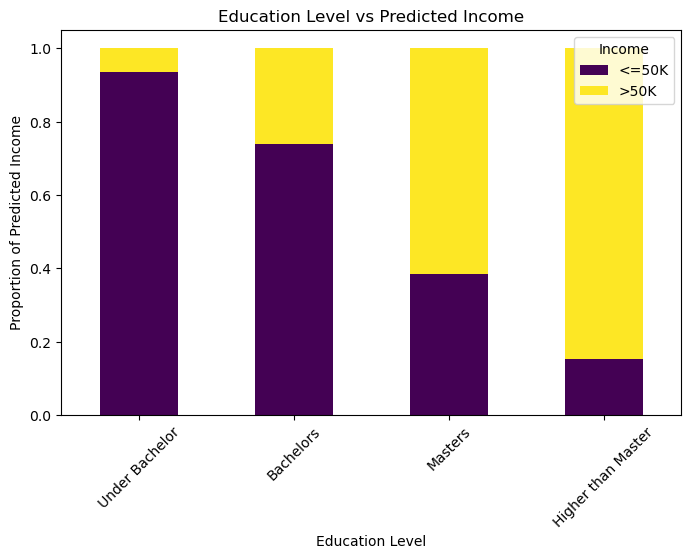

In [37]:
X_val_pred = X_val
X_val_pred["predicted_income"] = rounded
bins = [1, 9, 13, 14, X_val_pred['education-num'].max()]
labels = ['Under Bachelor', 'Bachelors', 'Masters', 'Higher than Master']
X_val_pred['education_num_bin'] = pd.cut(
    X_val_pred['education-num'], bins=bins, labels=labels, include_lowest=True
)


edu_num_crosstab = pd.crosstab(
    X_val_pred['education_num_bin'],
    X_val_pred['predicted_income'],
    normalize='index'
)

edu_num_crosstab.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5),
    colormap='viridis'
)
plt.ylabel('Proportion of Predicted Income')
plt.xlabel('Education Level')
plt.title('Education Level vs Predicted Income')
plt.legend(title='Income', labels=['<=50K', '>50K'])
plt.xticks(rotation=45)
plt.show()

**We can see that people with higher education level tend to be associated with predicted income over 50,000 dollar. This is intuitive since people with higher education level usaully have stronger skills and more likely to be preffered by large firms which offers high salary.**

- **From b. we know that top three categorical predictors are `marital-status`, `occupation`, and `relationship`**

/tmp/ipykernel_2107886/3114341189.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='predicted_income', data=prop_df, ax=axes[i], palette='viridis')
/tmp/ipykernel_2107886/3114341189.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='predicted_income', data=prop_df, ax=axes[i], palette='viridis')
/tmp/ipykernel_2107886/3114341189.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='predicted_income', data=prop_df, ax=axes[i], palette='viridis')


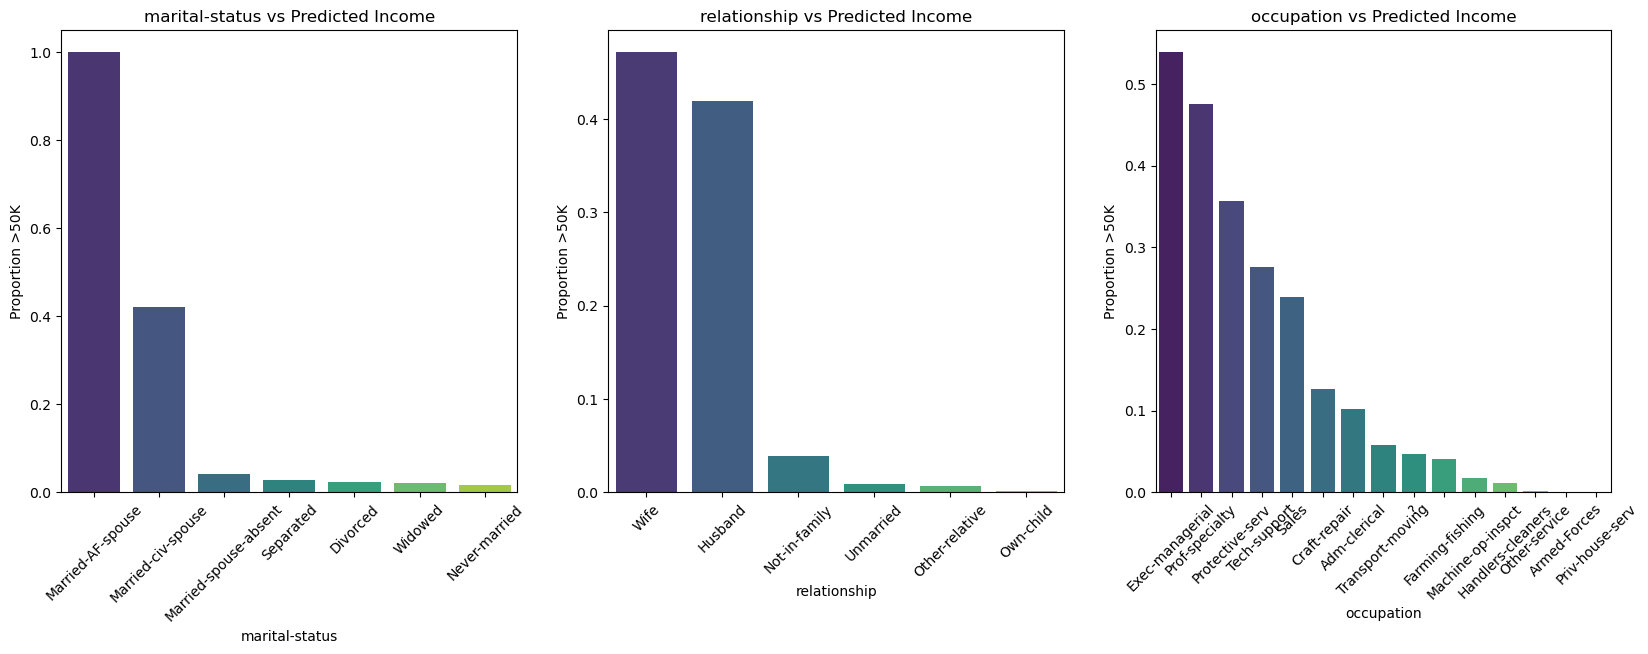

In [38]:
top_categorical = ['marital-status', 'relationship', 'occupation']
fig, axes = plt.subplots(1, 3, figsize=(20,6))
X_val_pred = X_val
X_val_pred["predicted_income"] = rounded

for i, feature in enumerate(top_categorical):

    prop_df = (X_val_pred.groupby(feature)['predicted_income'].mean().sort_values(ascending=False).reset_index())
    
    sns.barplot(x=feature, y='predicted_income', data=prop_df, ax=axes[i], palette='viridis')
    
    axes[i].set_ylabel('Proportion >50K')
    axes[i].set_xlabel(feature)
    axes[i].set_title(f'{feature} vs Predicted Income')
    axes[i].tick_params(axis='x', rotation=45)

plt.show()

**We can see from the graphs that occupations in executive management, professional specialties, protective services, and technology-related fields tend to have higher income levels. This is intuitive, as these roles typically require higher qualifications, greater responsibility, and more complex skill sets.**

### f.

### Construct a histogram of one numeric variable which is important in the model, with an overlay of income. (You may wish to use “normalize” to increase contrast.) Then construct a histogram of one numeric variable which is not important in the model, with an overlay of income. Do the histograms support the findings of the neural network?

**First we plot a histogram of a numeric important variable `capital-gain`**

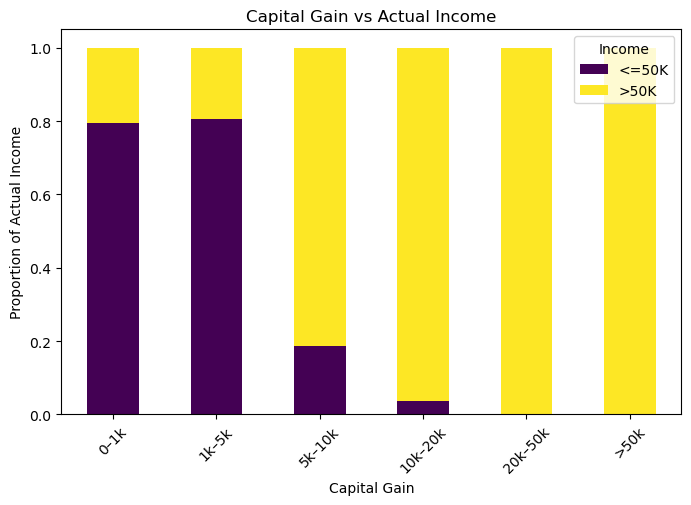

In [39]:
X_val_capt = X_val
X_val_capt['actual_income'] = y_val.values
bins = [0, 1000, 5000, 10000, 20000, 50000, X_val_capt['capital-gain'].max()]
labels = ['0–1k', '1k–5k', '5k–10k', '10k–20k', '20k–50k', '>50k']
X_val_capt['capital_gain_bin'] = pd.cut(
    X_val_capt['capital-gain'], bins=bins, labels=labels, include_lowest=True
)

capital_crosstab = pd.crosstab(
    X_val_capt['capital_gain_bin'],
    X_val_capt['actual_income'],
    normalize='index'
)

capital_crosstab.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5),
    colormap='viridis'
)
plt.ylabel('Proportion of Actual Income')
plt.xlabel('Capital Gain')
plt.title('Capital Gain vs Actual Income')
plt.legend(title='Income', labels=['<=50K', '>50K'])
plt.xticks(rotation=45)
plt.show()

**Then we plot a histogram of a numeric not important variable `demogweight`**

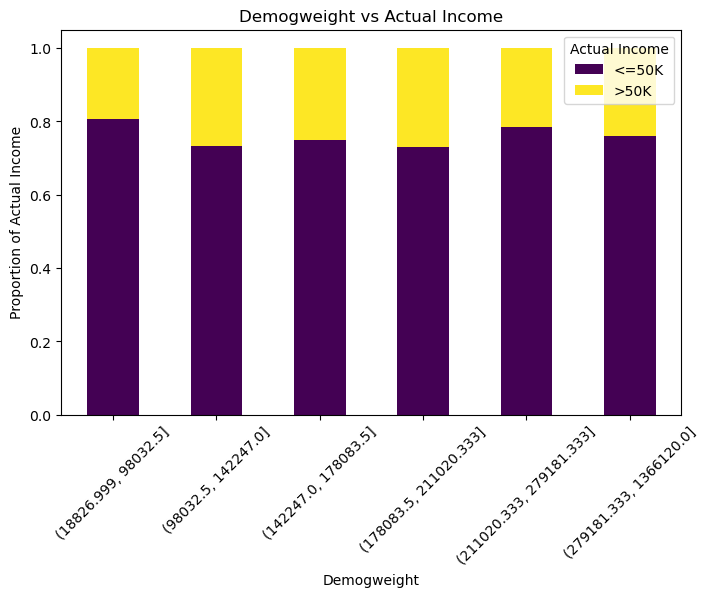

In [40]:
X_val_demo = X_val
X_val_demo['actual_income'] = y_val.values
X_val_demo['demogweight_bin'] = pd.qcut(X_val_demo['demogweight'], q=6)
demo_crosstab = pd.crosstab(
    X_val_demo['demogweight_bin'],
    X_val_demo['actual_income'],
    normalize='index'
)


demo_crosstab.plot(kind='bar', stacked=True, figsize=(8,5), colormap='viridis')
plt.ylabel('Proportion of Actual Income')
plt.xlabel('Demogweight')
plt.title('Demogweight vs Actual Income')
plt.legend(title='Actual Income', labels=['<=50K', '>50K'])
plt.xticks(rotation=45)
plt.show()

**We can observe from the histograms that for different capital gain level, the income level differs a lot, indicating larger capital gain, more income. However, the income level does not vary too much for different demoweight level. This conclusion supports findings from neural network**

## Part Two

### Data Transformation and Re-Construction

In [41]:
data.head()

,age,workclass,demogweight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K.
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K.
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K.
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K.
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K.


In [75]:
df_clean = data
df_clean = df_clean.drop(columns=['education'])
df_clean['income'] = df['income'].replace({'>50K.': 1, '<=50K.': 0})
df_clean.head()

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [43]:
print(df_clean.describe())

for c in categorical:
    print(df_clean[c].value_counts())

                age   demogweight  education-num  capital-gain  capital-loss  \
count  25000.000000  2.500000e+04   25000.000000  25000.000000   25000.00000   
mean      38.606920  1.897418e+05      10.081440   1088.579040      86.49992   
std       13.687769  1.052947e+05       2.557035   7486.621197     401.25358   
min       17.000000  1.228500e+04       1.000000      0.000000       0.00000   
25%       28.000000  1.179630e+05       9.000000      0.000000       0.00000   
50%       37.000000  1.783530e+05      10.000000      0.000000       0.00000   
75%       48.000000  2.368610e+05      12.000000      0.000000       0.00000   
max       90.000000  1.484705e+06      16.000000  99999.000000    4356.00000   

       hours-per-week        income  
count    25000.000000  25000.000000  
mean        40.407440      0.239360  
std         12.299267      0.426701  
min          1.000000      0.000000  
25%         40.000000      0.000000  
50%         40.000000      0.000000  
75%         4

**We see that `workclass`, `occupation`, and `native-country` columns have large amount of "?" values as one of their class, it is not making sense to one-hot encode "?" as a class and train the mode accordingly, therefore, we might need to interpret these "?" values as missing data, and try to transform them into meaningful values**

**First split the data into X and Y and also do the train/test split:**

In [76]:
X = df_clean.iloc[:, :13]
y = df_clean.iloc[:, -1]

In [77]:
# split the training data into train validate sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#### - Method 1: Replace "?" as Mode 

In [78]:
X_train_m1 = X_train.copy()
y_train_m1 = y_train.copy()
X_test_m1 = X_test.copy()
y_test_m1 = y_test.copy()

X_train_m1['workclass'] = X_train_m1['workclass'].replace({'?': str(X['workclass'].mode().values[0])})
X_train_m1['occupation'] = X_train_m1['occupation'].replace({'?': str(X['occupation'].mode().values[0])})
X_train_m1['native-country'] = X_train_m1['native-country'].replace({'?': str(X['native-country'].mode().values[0])})

X_test_m1['workclass'] = X_test_m1['workclass'].replace({'?': str(X['workclass'].mode().values[0])})
X_test_m1['occupation'] = X_test_m1['occupation'].replace({'?': str(X['occupation'].mode().values[0])})
X_test_m1['native-country'] = X_test_m1['native-country'].replace({'?': str(X['native-country'].mode().values[0])})

In [48]:
for c in ['workclass', 'occupation', 'native-country']:
    print(X_train_m1[c].value_counts())

workclass
Private             15024
Self-emp-not-inc     1582
Local-gov            1300
State-gov             803
Self-emp-inc          684
Federal-gov           594
Without-pay             9
Never-worked            4
Name: count, dtype: int64
occupation
Prof-specialty       3682
Craft-repair         2500
Exec-managerial      2455
Adm-clerical         2341
Sales                2262
Other-service        2016
Machine-op-inspct    1243
Transport-moving      971
Handlers-cleaners     830
Farming-fishing       618
Tech-support          569
Protective-serv       405
Priv-house-serv       103
Armed-Forces            5
Name: count, dtype: int64
native-country
United-States                 18292
Mexico                          395
Philippines                     117
Canada                           85
Germany                          84
Puerto-Rico                      78
Cuba                             62
England                          61
El-Salvador                      57
South           

**Now we preprocess the data use for method 1**

In [49]:
# build preprocessor using pipelines for future transformation
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

In [50]:
# fit preprocessor, transform to dense arrays
X_train_m1_enc = preprocessor.fit_transform(X_train_m1)
X_test_m1_enc = preprocessor.transform(X_test_m1)

X_train_m1_enc = X_train_m1_enc.toarray()
X_test_m1_enc = X_test_m1_enc.toarray()

In [51]:
X_train_m1_enc

array([[0.1369863 , 0.13983714, 0.6       , ..., 0.        , 0.        ,
        0.        ],
       [0.20547945, 0.23062985, 0.6       , ..., 1.        , 0.        ,
        0.        ],
       [0.12328767, 0.05717255, 0.8       , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.04109589, 0.13891417, 0.53333333, ..., 0.        , 0.        ,
        0.        ],
       [0.20547945, 0.12765447, 0.8       , ..., 1.        , 0.        ,
        0.        ],
       [0.56164384, 0.08796539, 0.13333333, ..., 0.        , 0.        ,
        0.        ]], shape=(20000, 89))

In [52]:
def build_model(optimizer='RMSprop', lr=1e-3, units=32, act='relu'):
    model = Sequential(name='ANN_Tunable')
    model.add(Input(shape=(X_train_m1_enc.shape[1],), name='input_features'))
    model.add(Dense(units, activation=act, kernel_initializer='glorot_uniform', name='hidden'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    
    if isinstance(optimizer, str):
        opt_name = optimizer.lower()
        if opt_name == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
        elif opt_name in ("sgd", "sgd_m"):
            opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        elif opt_name == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=lr)
        else:
            opt = tf.keras.optimizers.get(optimizer)
    else:
        opt = optimizer
        
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
"""
clf = KerasClassifier(model = build_model, epochs=40, batch_size=16, verbose=2)
param_grid = {
    "model__units": [16, 32, 64],
    "model__optimizer": ["RMSprop", "sgd", "Adam"],
    "model__lr": [1e-2, 1e-3]
}

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(clf, param_grid=param_grid, cv=kfold, scoring="accuracy", n_jobs=-1)

grid.fit(X_train_m1_enc, y_train_m1)
"""

In [ ]:
"""
print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)
"""

In [53]:
model = Sequential(name='ANN_M1')
model.add(Input(shape=(X_train_m1_enc.shape[1],), name='input_features'))
model.add(Dense(32, activation="relu", kernel_initializer='glorot_uniform', name='hidden'))
model.add(Dense(1, activation='sigmoid', name='output'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_m1 = model.fit(X_train_m1_enc, y_train_m1, epochs=40, batch_size=16, verbose=2)
predictions_m1 = model.predict(X_test_m1_enc)

rounded = [round(x[0]) for x in predictions]

test_acc = accuracy_score(y_test_m1, rounded)
print("Test accuracy:", test_acc)

Epoch 1/40
1250/1250 - 1s - 1ms/step - accuracy: 0.8134 - loss: 0.3909
Epoch 2/40
1250/1250 - 1s - 752us/step - accuracy: 0.8385 - loss: 0.3446
Epoch 3/40
1250/1250 - 1s - 746us/step - accuracy: 0.8460 - loss: 0.3311
Epoch 4/40
1250/1250 - 1s - 772us/step - accuracy: 0.8495 - loss: 0.3243
Epoch 5/40
1250/1250 - 1s - 758us/step - accuracy: 0.8515 - loss: 0.3208
Epoch 6/40
1250/1250 - 1s - 757us/step - accuracy: 0.8521 - loss: 0.3188
Epoch 7/40
1250/1250 - 1s - 752us/step - accuracy: 0.8535 - loss: 0.3172
Epoch 8/40
1250/1250 - 1s - 816us/step - accuracy: 0.8536 - loss: 0.3161
Epoch 9/40
1250/1250 - 1s - 777us/step - accuracy: 0.8539 - loss: 0.3150
Epoch 10/40
1250/1250 - 1s - 762us/step - accuracy: 0.8535 - loss: 0.3139
Epoch 11/40
1250/1250 - 1s - 747us/step - accuracy: 0.8545 - loss: 0.3129
Epoch 12/40
1250/1250 - 1s - 759us/step - accuracy: 0.8550 - loss: 0.3120
Epoch 13/40
1250/1250 - 1s - 733us/step - accuracy: 0.8549 - loss: 0.3111
Epoch 14/40
1250/1250 - 1s - 773us/step - accurac

#### - Method 2: Delete "?" values

In [ ]:
X_train_m2 = X_train.copy()
y_train_m2 = y_train.copy()
X_test_m2 = X_test.copy()
y_test_m2 = y_test.copy()

X_train_m2 = X_train_m2[X_train_m2['workclass'] != '?']
X_train_m2 = X_train_m2[X_train_m2['occupation'] != '?']
X_train_m2 = X_train_m2[X_train_m2['native-country'] != '?']

X_test_m2 = X_test_m2[X_test_m2['workclass'] != '?']
X_test_m2 = X_test_m2[X_test_m2['occupation'] != '?']
X_test_m2 = X_test_m2[X_test_m2['native-country'] != '?']

# drop the corresponding y rows (index-aligned, order preserved)
y_train_m2 = y_train_m2.loc[X_train_m2.index]
y_test_m2  = y_test_m2.loc[X_test_m2.index]

In [ ]:
for c in ['workclass', 'occupation', 'native-country']:
    print(X_train_m2[c].value_counts())

In [ ]:
# build preprocessor using pipelines for future transformation
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

In [ ]:
# fit preprocessor, transform to dense arrays
X_train_m2_enc = preprocessor.fit_transform(X_train_m2)
X_test_m2_enc = preprocessor.transform(X_test_m2)

X_train_m2_enc = X_train_m2_enc.toarray()
X_test_m2_enc = X_test_m2_enc.toarray()

In [ ]:
def build_model(optimizer='RMSprop', lr=1e-3, units=32, act='relu'):
    model = Sequential(name='ANN_Tunable')
    model.add(Input(shape=(X_train_m2_enc.shape[1],), name='input_features'))
    model.add(Dense(units, activation=act, kernel_initializer='glorot_uniform', name='hidden'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    
    if isinstance(optimizer, str):
        opt_name = optimizer.lower()
        if opt_name == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
        elif opt_name in ("sgd", "sgd_m"):
            opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        elif opt_name == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=lr)
        else:
            opt = tf.keras.optimizers.get(optimizer)
    else:
        opt = optimizer
        
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
"""
clf = KerasClassifier(model = build_model, epochs=40, batch_size=16, verbose=2)
param_grid = {
    "model__units": [16, 32, 64],
    "model__optimizer": ["RMSprop", "sgd", "Adam"],
    "model__lr": [1e-2, 1e-3]
}

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(clf, param_grid=param_grid, cv=kfold, scoring="accuracy", n_jobs=-1)

grid.fit(X_train_m2_enc, y_train_m2)
"""

In [ ]:
"""
print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)
"""

#### - Method 3: Predict "?" values using other meaningful rows and columns

In [ ]:
X_train_m3 = X_train.copy()
y_train_m3 = y_train.copy()
X_test_m3 = X_test.copy()
y_test_m3 = y_test.copy()

In [ ]:
# Assumes you already have: X_train, X_test  (features only; no 'income' here)
targets = ["workclass", "occupation", "native-country"]

# treat "?" as missing for target columns
for col in targets:
    if col in X_train_m3.columns:
        X_train_m3[col] = X_train_m3[col].replace("?", np.nan)
    if col in X_test.columns:
        X_test_m3[col] = X_test_m3[col].replace("?", np.nan)

for col in targets:
    if col not in X_train_m3.columns: 
        continue

    # features exclude the column being imputed
    feat_cols = [c for c in X_train_m3.columns if c != col]

    # train only on rows where the target column is known in X_train
    known = X_train_m3[col].notna()

        
    numeric_transformer = Pipeline(steps=[
        ('imputer', impute.SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', impute.SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    cat_cols = [c for c in feat_cols if c not in numerical]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical),
            ('cat', categorical_transformer, cat_cols)
        ]
    )

    clf = Pipeline([("prep", preprocessor), ("mdl", RidgeClassifier())])
    clf.fit(X_train_m3.loc[known, feat_cols], X_train_m3.loc[known, col])

    # predict and fill missing in both splits (index and order preserved)
    for df in (X_train_m3, X_test_m3):
        miss = df[col].isna()
        if miss.any():
            df.loc[miss, col] = clf.predict(df.loc[miss, feat_cols])

In [ ]:
X_train_m3.workclass.value_counts()

In [ ]:
# build preprocessor using pipelines for future transformation
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

In [ ]:
# fit preprocessor, transform to dense arrays
X_train_m3_enc = preprocessor.fit_transform(X_train_m3)
X_test_m3_enc = preprocessor.transform(X_test_m3)

X_train_m3_enc = X_train_m3_enc.toarray()
X_test_m3_enc = X_test_m3_enc.toarray()

In [ ]:
def build_model(optimizer='RMSprop', lr=1e-3, units=32, act='relu'):
    model = Sequential(name='ANN_Tunable')
    model.add(Input(shape=(X_train_m3_enc.shape[1],), name='input_features'))
    model.add(Dense(units, activation=act, kernel_initializer='glorot_uniform', name='hidden'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    
    if isinstance(optimizer, str):
        opt_name = optimizer.lower()
        if opt_name == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
        elif opt_name in ("sgd", "sgd_m"):
            opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        elif opt_name == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=lr)
        else:
            opt = tf.keras.optimizers.get(optimizer)
    else:
        opt = optimizer
        
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
"""
clf = KerasClassifier(model = build_model, epochs=40, batch_size=16, verbose=2)
param_grid = {
    "model__units": [16, 32, 64],
    "model__optimizer": ["RMSprop", "sgd", "Adam"],
    "model__lr": [1e-2, 1e-3]
}

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(clf, param_grid=param_grid, cv=kfold, scoring="accuracy", n_jobs=-1)

grid.fit(X_train_m3_enc, y_train_m3)
""""""

In [ ]:
"""
print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)
"""

#### - Method 4: Replace "?" as "Unknown" 

In [ ]:
X_train_m4 = X_train.copy()
y_train_m4 = y_train.copy()
X_test_m4 = X_test.copy()
y_test_m4 = y_test.copy()

X_train_m4['workclass'] = X_train_m4['workclass'].replace({'?': "Unknown"})
X_train_m4['occupation'] = X_train_m4['occupation'].replace({'?': "Unknown"})
X_train_m4['native-country'] = X_train_m4['native-country'].replace({'?': "Unknown"})

X_test_m4['workclass'] = X_test_m4['workclass'].replace({'?': "Unknown"})
X_test_m4['occupation'] = X_test_m4['occupation'].replace({'?': "Unknown"})
X_test_m4['native-country'] = X_test_m4['native-country'].replace({'?': "Unknown"})

In [ ]:
for c in ['workclass', 'occupation', 'native-country']:
    print(X_train_m4[c].value_counts())

In [ ]:
# build preprocessor using pipelines for future transformation
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

In [ ]:
# fit preprocessor, transform to dense arrays
X_train_m4_enc = preprocessor.fit_transform(X_train_m4)
X_test_m4_enc = preprocessor.transform(X_test_m4)

X_train_m4_enc = X_train_m4_enc.toarray()
X_test_m4_enc = X_test_m4_enc.toarray()

In [ ]:
def build_model(optimizer='RMSprop', lr=1e-3, units=32, act='relu'):
    model = Sequential(name='ANN_Tunable')
    model.add(Input(shape=(X_train_m4_enc.shape[1],), name='input_features'))
    model.add(Dense(units, activation=act, kernel_initializer='glorot_uniform', name='hidden'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    
    if isinstance(optimizer, str):
        opt_name = optimizer.lower()
        if opt_name == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
        elif opt_name in ("sgd", "sgd_m"):
            opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        elif opt_name == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=lr)
        else:
            opt = tf.keras.optimizers.get(optimizer)
    else:
        opt = optimizer
        
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
"""
clf = KerasClassifier(model = build_model, epochs=40, batch_size=16, verbose=2)
param_grid = {
    "model__units": [16, 32, 64],
    "model__optimizer": ["RMSprop", "sgd", "Adam"],
    "model__lr": [1e-2, 1e-3]
}

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(clf, param_grid=param_grid, cv=kfold, scoring="accuracy", n_jobs=-1)

grid.fit(X_train_m4_enc, y_train_m4)
"""

In [ ]:
"""
print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)
"""

**From the four data transformation methods we tried, we can see that the method works the best is to replace "?" values into mode, or predict "?" values using othern known predictors and rows**

**Therefore, for the following tuning steps, method 1 (data with "?" values replaced by mode) will be used**

### Tune on Layer sand parameters

In [54]:
X_train_mode = X_train_m1.copy()
y_train_mode = y_train_m1.copy()
X_test_mode = X_test_m1.copy()
y_test_mode = y_test_m1.copy()

In [55]:
X_train_mode.workclass.value_counts()

workclass
Private             15024
Self-emp-not-inc     1582
Local-gov            1300
State-gov             803
Self-emp-inc          684
Federal-gov           594
Without-pay             9
Never-worked            4
Name: count, dtype: int64

In [56]:
# build preprocessor using pipelines for future transformation
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

In [57]:
# fit preprocessor, transform to dense arrays
X_train_mode_enc = preprocessor.fit_transform(X_train_mode)
X_test_mode_enc = preprocessor.transform(X_test_mode)

X_train_mode_enc = X_train_mode_enc.toarray()
X_test_mode_enc = X_test_mode_enc.toarray()

In [63]:
y_np = np.asarray(y_train_mode).astype("int64").ravel()
X_enc = X_train_mode_enc
input_dim = X_enc.shape[1]

def make_model(hidden_units=32, hidden_layers=1, l2_reg=1e-4,
               optimizer="RMSprop", lr=1e-3, act="relu"):
    m = Sequential(name="income_nn")
    m.add(Input(shape=(input_dim,), name="input"))
    for i in range(hidden_layers):
        m.add(Dense(hidden_units, activation=act,
                    kernel_initializer="glorot_uniform",
                    kernel_regularizer=l2(l2_reg),
                    name=f"hidden_{i+1}"))
    m.add(Dense(1, activation="sigmoid", name="output"))

    name = optimizer.lower()
    if name == "rmsprop":
        opt = RMSprop(learning_rate=lr)
    if name in ("sgd", "sgd_m"):
        opt = SGD(learning_rate=lr, momentum=0.9)
    if name == "adam":
        opt = Adam(learning_rate=lr)
        
    m.compile(optimizer=opt, loss="binary_crossentropy",
              metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")])
    return m

grid = {
    "hidden_units":   [32, 64],
    "hidden_layers":  [1, 2],
    "l2_reg":         [1e-4, 3e-4],
    "optimizer":      ["RMSprop", "Adam"],
    "lr":             [1e-2, 1e-3],
}

all_configs = [
    dict(zip(grid.keys(), vals))
    for vals in itertools.product(*grid.values())
]
print(f"Total configs in full grid: {len(all_configs)}")

kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
EPOCHS, BATCH_SIZE = 40, 16

"""
cv_rows = []
for ci, params in enumerate(all_configs, start=1):
    fold_accs, fold_aucs = [], []
    print(f"\n[{ci}/{len(all_configs)}] Params: {params}")
    for fold, (tr_idx, va_idx) in enumerate(kfold.split(X_enc), start=1):
        X_tr, y_tr = X_enc[tr_idx], y_np[tr_idx]
        X_va, y_va = X_enc[va_idx], y_np[va_idx]

        model = make_model(**params)
        model.fit(X_tr, y_tr, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

        # Robust evaluation
        y_va_proba = model.predict(X_va, verbose=0).ravel()
        y_va_pred  = (y_va_proba >= 0.5).astype(int)
        acc = float((y_va_pred == y_va).mean())              # selection metric
        auc = float(roc_auc_score(y_va, y_va_proba))         # just for reference

        fold_accs.append(acc); fold_aucs.append(auc)
        # print(f"  Fold {fold}: ACC={acc:.4f} | AUC={auc:.4f}")

    row = {
        **params,
        "mean_acc": float(np.mean(fold_accs)), "std_acc": float(np.std(fold_accs)),
        "mean_auc": float(np.mean(fold_aucs)), "std_auc": float(np.std(fold_aucs)),
    }
    cv_rows.append(row)
    print(f" => mean ACC={row['mean_acc']:.4f} (±{row['std_acc']:.4f}) | "
          f"mean AUC={row['mean_auc']:.4f} (±{row['std_auc']:.4f})")

cv_df = pd.DataFrame(cv_rows)\
         .sort_values(["mean_acc", "mean_auc"], ascending=False)\
         .reset_index(drop=True)

print("\nTop configs by mean ACC:")
print(cv_df.head(10)[["hidden_units","hidden_layers","dropout","l2_reg","optimizer","lr","mean_acc","std_acc","mean_auc","std_auc"]])

best = cv_df.iloc[0].to_dict()
best_params = {k: best[k] for k in ["hidden_units","hidden_layers","dropout","l2_reg","optimizer","lr"]}
print("\nBest by ACC:", best_params, "| mean_acc=", f"{best['mean_acc']:.4f}")
"""

Total configs in full grid: 32

[1/32] Params: {'hidden_units': 32, 'hidden_layers': 1, 'l2_reg': 0.0001, 'optimizer': 'RMSprop', 'lr': 0.01}
 => mean ACC=0.8402 (±0.0092) | mean AUC=0.8917 (±0.0103)

[2/32] Params: {'hidden_units': 32, 'hidden_layers': 1, 'l2_reg': 0.0001, 'optimizer': 'RMSprop', 'lr': 0.001}
 => mean ACC=0.8469 (±0.0085) | mean AUC=0.9030 (±0.0060)

[3/32] Params: {'hidden_units': 32, 'hidden_layers': 1, 'l2_reg': 0.0001, 'optimizer': 'Adam', 'lr': 0.01}
 => mean ACC=0.8425 (±0.0117) | mean AUC=0.9021 (±0.0063)

[4/32] Params: {'hidden_units': 32, 'hidden_layers': 1, 'l2_reg': 0.0001, 'optimizer': 'Adam', 'lr': 0.001}
 => mean ACC=0.8498 (±0.0095) | mean AUC=0.9073 (±0.0058)

[5/32] Params: {'hidden_units': 32, 'hidden_layers': 1, 'l2_reg': 0.0003, 'optimizer': 'RMSprop', 'lr': 0.01}
 => mean ACC=0.8381 (±0.0089) | mean AUC=0.8918 (±0.0058)

[6/32] Params: {'hidden_units': 32, 'hidden_layers': 1, 'l2_reg': 0.0003, 'optimizer': 'RMSprop', 'lr': 0.001}
 => mean ACC=0.8

KeyboardInterrupt: 

In [64]:
model_train = Sequential(name="income_nn")
model_train.add(Input(shape=(input_dim,), name="input"))
model_train.add(Dense(units=64, activation="relu",
            kernel_initializer="glorot_uniform",
            kernel_regularizer=l2(0.0003),
            name="hidden_1"))
model_train.add(Dense(units=32, activation="relu", name="hidden_2"))
model_train.add(Dense(1, activation="sigmoid", name="output"))

model_train.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy",
              metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")])

model_train.fit(X_train_mode_enc, y_train_mode, epochs=40, batch_size=16, verbose=5)

model = Sequential(name="ANN_Tunable")
model.add(Input(shape=(meta["n_features_in_"],), name="input_features"))
model.add(Dense(units, activation=act, kernel_initializer="glorot_uniform", name="hidden"))
model.add(Dense(units2, activation=act, kernel_initializer="glorot_uniform", name="hidden2"))
model.add(Dense(1, activation="sigmoid", name="output"))

Epoch 1/40
Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Epoch 8/40
Epoch 9/40
Epoch 10/40
Epoch 11/40
Epoch 12/40
Epoch 13/40
Epoch 14/40
Epoch 15/40
Epoch 16/40
Epoch 17/40
Epoch 18/40
Epoch 19/40
Epoch 20/40
Epoch 21/40
Epoch 22/40
Epoch 23/40
Epoch 24/40
Epoch 25/40
Epoch 26/40
Epoch 27/40
Epoch 28/40
Epoch 29/40
Epoch 30/40
Epoch 31/40
Epoch 32/40
Epoch 33/40
Epoch 34/40
Epoch 35/40
Epoch 36/40
Epoch 37/40
Epoch 38/40
Epoch 39/40
Epoch 40/40


In [67]:
predictions = model_train.predict(X_test_mode_enc)

rounded = [round(x[0]) for x in predictions]

test_acc = accuracy_score(y_test_mode, rounded)
print("Test accuracy:", test_acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
Test accuracy: 0.833


**Add Second layer XGBoost model using output of first layer ANN model as part of input**

In [68]:
X = np.asarray(X_train_mode_enc)
y = np.asarray(y_train_mode).astype("int64").ravel()

input_dim = X.shape[1]
EPOCHS, BATCH = 40, 16
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

def build_nn():
    m = Sequential(name="income_nn")
    m.add(Input(shape=(input_dim,), name="input"))
    m.add(Dense(64, activation="relu",
                kernel_initializer="glorot_uniform",
                kernel_regularizer=l2(3e-4), name="hidden_1"))
    m.add(Dense(32, activation="relu", name="hidden_2"))
    m.add(Dense(1, activation="sigmoid", name="output"))
    m.compile(optimizer=Adam(learning_rate=1e-3),
              loss="binary_crossentropy",
              metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")])
    return m

oof = np.zeros(len(y), dtype=float)
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

for tr, va in kf.split(X):
    m = build_nn()
    m.fit(X[tr], y[tr], epochs=EPOCHS, batch_size=BATCH, verbose=0)
    oof[va] = m.predict(X[va], verbose=0).ravel()



X_train_aug = np.hstack([X, oof.reshape(-1, 1)])


tree = XGBClassifier(
    n_estimators=600, learning_rate=0.05, max_depth=5,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    random_state=SEED, n_jobs=-1, objective="binary:logistic", eval_metric="logloss"
)

tree.fit(X_train_aug, y)

p_train_2 = tree.predict_proba(X_train_aug)[:, 1]
print(f"Ensemble (train) — ACC={accuracy_score(y, (p_train_2>=0.5).astype(int)):.4f} | AUC={roc_auc_score(y, p_train_2):.4f}")

Ensemble (train) — ACC=0.9045 | AUC=0.9621


**Finally get accuracy 0.9045**

**Now we test the model using test set data**

In [69]:
X_te = np.asarray(X_test_mode_enc)
y_te = np.asarray(y_test_mode).astype("int64").ravel()

nn_full = build_nn()
nn_full.fit(X, y, epochs=EPOCHS, batch_size=BATCH, verbose=0)

p_nn_te = nn_full.predict(X_te, verbose=0).ravel()
X_test_aug = np.hstack([X_te, p_nn_te.reshape(-1, 1)])

p_test_2 = tree.predict_proba(X_test_aug)[:, 1]
print(f"Ensemble (test)  — ACC={(p_test_2>=0.5).astype(int).mean() if y_te is None else ((p_test_2>=0.5).astype(int)==y_te).mean():.4f} | "
      f"AUC={roc_auc_score(y_te, p_test_2):.4f}")

Ensemble (test)  — ACC=0.8724 | AUC=0.9296


**Now we train the model using entire training dataset**

In [70]:
X_all = np.vstack([X, X_te])
y_all = np.concatenate([y, y_te])

nn_all = build_nn()
nn_all.fit(X_all, y_all, epochs=EPOCHS, batch_size=BATCH, verbose=0)
p_nn_all = nn_all.predict(X_all, verbose=0).ravel()
X_all_aug = np.hstack([X_all, p_nn_all.reshape(-1, 1)])

tree_full = XGBClassifier(**tree.get_params())
tree_full.fit(X_all_aug, y_all)
print("Final stacked model trained on ALL data.")

Final stacked model trained on ALL data.


In [90]:
# # save layer 1 and layer 2model
# import joblib, platform
# from datetime import datetime

# nn_all.save("nn_all.keras")

# tree_meta = {}
# try:  # XGBoost
#     tree_full.get_booster().save_model("xgb_model.json")
#     tree_meta["type"] = "xgboost"
# except Exception:
#     joblib.dump(tree_full, "tree_full.joblib")
#     tree_meta["type"] = "pickle"

# # Preprocessor + manifest
# joblib.dump(preprocessor, "preprocessor.joblib")
# with open("manifest.json", "w") as f:
#     json.dump({
#         "created": datetime.utcnow().isoformat()+"Z",
#         "python": platform.python_version(),
#         "tensorflow": tf.__version__,
#         "tree": tree_meta,
#         "threshold": 0.5
#     }, f, indent=2)

/tmp/ipykernel_2107886/3025606144.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created": datetime.utcnow().isoformat()+"Z",


### Load Test Dataset => Preprocess => Make Predictions and Save

In [81]:
data_test = pd.read_csv("../Data/USCensusTest.csv", sep=',', header=0)
data_test = data_test.drop(columns=['education'])
data_test.head()

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,44,Private,162028,7,Divorced,Sales,Unmarried,White,Female,0,0,44,United-States
1,20,Private,197997,10,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States
2,46,Private,98350,6,Married-spouse-absent,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,37,China
3,39,Private,165848,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,United-States
4,34,Private,178615,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


In [82]:
data_test['workclass'] = data_test['workclass'].replace({'?': str(data['workclass'].mode().values[0])})
data_test['occupation'] = data_test['occupation'].replace({'?': str(data['occupation'].mode().values[0])})
data_test['native-country'] = data_test['native-country'].replace({'?': str(data['native-country'].mode().values[0])})

In [85]:
data_test

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,44,Private,162028,7,Divorced,Sales,Unmarried,White,Female,0,0,44,United-States
1,20,Private,197997,10,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States
2,46,Private,98350,6,Married-spouse-absent,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,37,China
3,39,Private,165848,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,United-States
4,34,Private,178615,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,27,Private,257302,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
7557,40,Private,154374,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
7558,58,Private,151910,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
7559,22,Private,201490,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [83]:
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

In [84]:
preprocessor.fit(X_train_m1)
data_test_enc = preprocessor.transform(data_test)

data_test_enc = data_test_enc.toarray()

In [86]:
data_test_enc

array([[0.36986301, 0.10169856, 0.4       , ..., 1.        , 0.        ,
        0.        ],
       [0.04109589, 0.12612706, 0.6       , ..., 1.        , 0.        ,
        0.        ],
       [0.39726027, 0.05845139, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.56164384, 0.09482688, 0.53333333, ..., 1.        , 0.        ,
        0.        ],
       [0.06849315, 0.12849934, 0.53333333, ..., 1.        , 0.        ,
        0.        ],
       [0.47945205, 0.18720338, 0.53333333, ..., 1.        , 0.        ,
        0.        ]], shape=(7561, 89))

In [87]:
X_new = np.asarray(data_test_enc)

p_nn = nn_all.predict(X_new, verbose=0).ravel()

X_new_aug = np.hstack([X_new, p_nn.reshape(-1, 1)])
p_final = tree_full.predict_proba(X_new_aug)[:, 1]
y_pred = (p_final >= 0.5).astype(int)

print("probs:", p_final[:5])
print("preds:", y_pred[:5])

probs: [1.7539646e-02 6.9464336e-04 4.3147619e-04 4.7225675e-01 4.9322951e-03]
preds: [0 0 0 0 0]


In [88]:
# save to ASCII txt file
y_pred = y_pred.astype(int)
np.savetxt("Team6predictions.txt", y_pred, fmt="%d", newline="\n")